 # Where is a hospital in Manhattan Downtown?

In this lab we will create 2 vector indices to answer a very simple question: if you are in Manhattan downtown, where is the nearest hospital? We will base our soultion on two sources of data:
- [Points of Interest dataset](https://drive.google.com/file/d/1LUudtCADqSxRl18ZzCzyPPGfhuUo2ZZs/view?usp=sharing). This is a 10% sample of a bigger dataset. Download and uncompress the file.
- [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start) or any other [equivalent service](https://gisgeography.com/geocoders/). For Google you will need to obtain a key. **PLEASE DO NOT SUBMIT THE KEY TO MOODLE :)**


# 0. Prepare the data

In [1]:
def draw_earth(xlim=(-180, +180), ylim=(-90, +90)):
    import matplotlib.pyplot
    import pandas as pd
    import json
    plt.figure(figsize=(15, 8))
    plt.xlim(xlim)
    plt.ylim(ylim)

    # this file also lives in github. Adjust the path if needed.
    df = pd.read_csv("../../datasets/world.csv")

    for row in df['geojson']:
        js = json.loads(row)
        polys = js['coordinates']
        for poly in polys:
            for pp in poly:
                x, y = [v[0] for v in pp], [v[1] for v in pp]
                plt.plot(x, y, color='gray')

Reading the dataset and storing coordinates in `GEO` matrix:

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# replace filename if you want to use another data file
# be careful! 2M points is still a big number and can eat significant amout of memory
with open("../../datasets/poi_sample01.pickle", "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000

# pure coordinated in compressed representation, 4B per number -> 16MB per array
GEO = np.array([v[0] for v in dataset], dtype=np.float16) # using float32 here to make sure all points are different. Trimming to float16 makes stuff coincide really a lot

N = len(dataset)
# free the memory
dataset = None
import gc
gc.collect()

0

Showing approximate dataset data distribution:

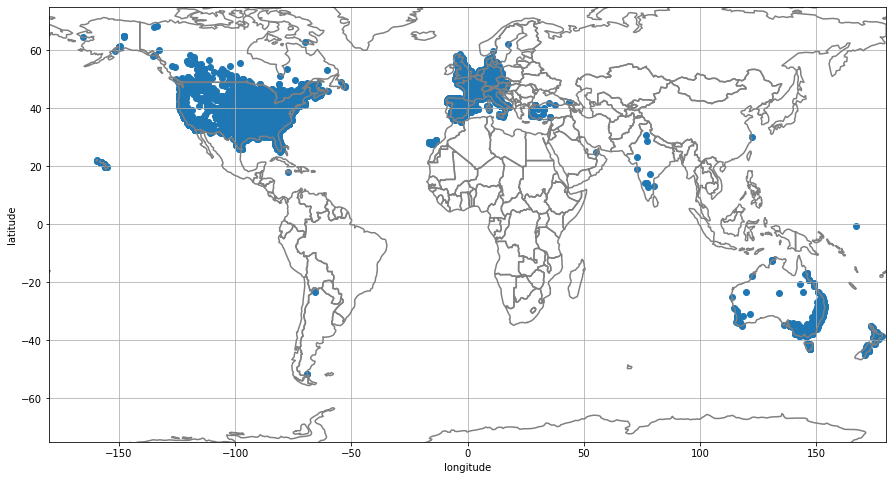

In [3]:
draw_earth(ylim=(-75, 75))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.scatter(GEO[::step, 0], GEO[::step, 1])
plt.show()

## 0.1. [1 point] Ok. Let's prepare ourselves to read the data from the hard drive

We will prepare id-based shards (data will be distributed into equal files with ranges `[0..capacity-1], [capacity..2*capacity-1], ...`. Each shard will store `capacity` elements. Your task is to complete the implementation with `iterate_dataset` function.

In [4]:
def split_shards(file, folder='shard', capacity=20000):
    import pickle, os, math, gc
    if not os.path.exists(folder):
        os.mkdir(folder)
    with open(file, "rb") as f:
        dataset = pickle.load(f)
    nshards = len(dataset) // capacity
    if nshards * capacity < len(dataset):
        nshards += 1
    
    for i in range(nshards):
        with open(f"{folder}/{i}", 'wb') as f:
            part = dataset[i * capacity:(i+1)*capacity]
            pickle.dump(part, f)
    dataset = None
    gc.collect()            

    
def dataset_get(indices, folder='shard', capacity=20000) -> list:
    result = []
    groups = {}
    for i in indices:
        x = i // capacity
        if x not in groups:
            groups[x] = []
        groups[x].append(i)
    for x in groups:
        with open(f"{folder}/{x}", "rb") as f:
            sha = pickle.load(f)
            for i in groups[x]:
                row = sha[i % capacity]
                result.append(row)
    return result


# should return iterator, which goes through all elements, consequently opening files
# use ``yield`` operator to simplify your code
def iterate_dataset(items, folder="shard", capacity=20000):
    for i in range(0, items, capacity):
        shard = i // capacity
        with open(f"{folder}/{shard}", 'rb') as f:
            shard = pickle.load(f)
        for item in shard:
            yield item

In [5]:
split_shards("../../datasets/poi_sample01.pickle")

asserts:

In [6]:
i = 0
for r in iterate_dataset(N):
    i += 1

assert i == N

asserts:

In [7]:
import numpy as np

for i in [137, 40000, 600000]:
    itm = dataset_get([i])
    print(GEO[i,:], itm[0][0])
    assert np.allclose(GEO[i,:], itm[0][0], atol=5*1e-2), ""

[12.08 48.03] [12.0809497833, 48.0439414978]
[152.6  -31.89] [152.614074707, -31.8914890289]
[-0.2117 47.16  ] [-0.2116519958, 47.1609649658]


In [8]:
dataset_get([1, 10, 1000234, N-1])

[([-58.4339539, -34.6028583],
  'CreationFlow, Professional, Computer Services. AR, Ciudad de Buenos Aires, Vera 15 3-B'),
 ([13.9706993103, 46.6813430786],
  'Bahnhof Ossiach-Bodensdorf. AT, Bodensdorf, '),
 ([-117.642377, 34.068324],
  'Industrial Labor Management, Professional, Management & Consulting. US, Ontario, 647 E E St'),
 ([28.0354352, -26.1470966],
  'ScoreGrid, Professional, Computer Services. ZA, Johannesburg, 158 Jan Smuts Avenue Rosebank')]

---

# And now the task!
Ok. We are ready to perform the following steps utilizing functions beyond:
1. Build **coordinate search index**. We will use it to obtain POI from the given region.
3. Implement **vector text embedding index** (Annoy, HNSW) to serve semantic queries.
3. Implement **geocoding** with cache. We will use it to obtain city coordinates.
4. Impement search for **double queries: town and location type**.

# 1. Create spacial index for points of interest

We will store dataset rows numbers as values, and coordinates as keys. Please use [KDtree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) or [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) from sklearn.

## 1.1. [5 points] Build the index and return it

Implement the following functions. To get the full grade:
- `build_geospacial_index` should build and return a search tree object: KDTree or BallTree.
- `kNN` accepts a 2D-point, `k` neighbours parameter, and returns **approximate** `k` neighbours (they can be different from the real neighbours).
- `inRadius` accepts a 2D-point, $L_2$ `radius`, and returns points inside the radius.

In [9]:
from sklearn.neighbors import BallTree
import itertools

class Index:
    def __init__(self, X, leaf_size):
        X = [ tuple(x) for x in X ]
        self.X_dedup = list(set(X))
        self.tree = BallTree(self.X_dedup, leaf_size)
        indices = dict()
        for i, x in enumerate(X):
            l = indices.get(x)
            if l is None:
                l = []
                indices[x] = l
            l.append(i)
        self.indices = indices

def build_geospacial_index(points: np.ndarray, leaf_size=5) -> Index: # or KDTree here
    index = Index(points, leaf_size)
    return index


def kNN(query_point: list, k: int, index: Index) -> list:
    print('kNN({}, {})'.format(query_point, k))
    idxs = index.tree.query([query_point], k, return_distance=False)[0]
    i = 0
    res = []
    # sometimes we return > k results to make sure all the duplicates are returned
    # tbh, we should load the original data at this point to refine the results, but meh, too much architecture changes
    while len(res) < k:
        res += index.indices[index.X_dedup[idxs[i]]]
        i += 1
        pass
    return res


def inRadius(query_point: list, r: float, index: Index) -> list:
    idxs = index.tree.query_radius([query_point], r)[0]
    return list(itertools.chain(*(index.indices[index.X_dedup[i]] for i in idxs)))

In [10]:
spaidx = build_geospacial_index(GEO)

In [11]:
test_id = 13

idx = kNN(GEO[test_id], 10, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

idx = inRadius(GEO[test_id], 0.0625, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

kNN([14.13 47.8 ], 10)
[13, 145, 351, 2178, 10783, 11968, 14229, 14999, 15497, 16282, 16505, 16642, 16702, 20423, 21021, 23285, 24681, 26327, 27584]
[13, 145, 351, 2178, 10783, 11968, 14229, 14999, 15497, 16282, 16505, 16642, 16702, 20423, 21021, 23285, 24681, 26327, 27584]


## 1.2. [4 points] Tricky assert

Some keys (coordinates) in the dataset (surprise!) are duplicates. Unfortunately search trees (in basic implemenation) cannot support duplicates. Thus you can follow one of the strategies:
- a key (coordinateS) corresponds to multiple values. This may require additional data strictures.
- improve the data (coordinates) to avoid collisions (e.g. lake sure they never coinside)

Pass the assert to get full points.

In [12]:
points = [1966663, 1480877, 2126566]
for p in points:
    x = GEO[p, :]
    r = kNN(x, 100, spaidx)
    print(f"{p} -> {r}")
    assert (p in r), "Query did not return itself"

kNN([-74.    40.75], 100)
1966663 -> [328379, 1432008, 1432421, 1432497, 1432616, 1433805, 1433887, 1434060, 1434761, 1435005, 1435473, 1436184, 1436275, 1437237, 1437915, 1438072, 1439530, 1440106, 1440128, 1440182, 1440420, 1440888, 1440940, 1441493, 1441948, 1442465, 1442840, 1443118, 1443302, 1443375, 1443526, 1444353, 1444680, 1445013, 1445038, 1445340, 1445549, 1445671, 1445683, 1447155, 1447393, 1447761, 1447889, 1448039, 1448093, 1448271, 1448317, 1448402, 1448863, 1448930, 1449687, 1449955, 1450231, 1450306, 1451206, 1451602, 1452433, 1452831, 1452858, 1453060, 1453255, 1453972, 1454076, 1454355, 1455070, 1455073, 1455283, 1455979, 1456395, 1456543, 1457478, 1457997, 1458005, 1458013, 1458066, 1458070, 1458158, 1458275, 1458395, 1459012, 1459092, 1459514, 1459921, 1461703, 1462076, 1462327, 1462521, 1462696, 1463328, 1463388, 1463789, 1463845, 1463890, 1464176, 1464349, 1464465, 1464627, 1465455, 1465541, 1465600, 1465716, 1465867, 1466162, 1466473, 1466930, 1467061, 1467840, 

## 1.3. [Optional demo] How leaf size influences build and search speed?

Let us look at how parameter of leaf size affects speed of search and construction

100%|██████████| 4/4 [00:19<00:00,  4.98s/it]


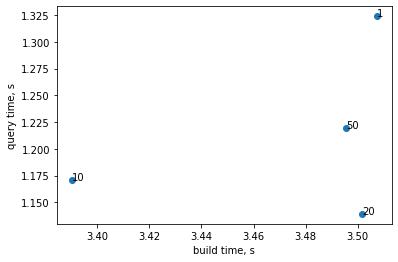

In [13]:
import random
import time
import matplotlib.pyplot as plt
import tqdm

queries = random.sample(range(N), 1000)
leaf_sizes = [1, 10, 20, 50]

build_times = []
query_times = []
for ls in tqdm.tqdm(leaf_sizes):
    start = time.time()
    idx = build_geospacial_index(GEO, ls)
    build_times.append(time.time() - start)
    
    start = time.time()
    for q in queries:
        d, r = spaidx.tree.query([GEO[q]], 10000, sort_results=False, breadth_first=True)
    query_times.append(time.time() - start)
    idx = None
    gc.collect()

plt.xlabel("build time, s")
plt.ylabel("query time, s")
plt.scatter(build_times, query_times)
for i, ls in enumerate(leaf_sizes):
    plt.annotate(str(ls), (build_times[i], query_times[i]))

## 1.4. [5 points] Range queries?

Ok, you have a **radius query**, but what about **rectangual ranges**? Using the functions you already wrote, please, implement the range query given `north-east` and `south-west` corners. Pass the asserts to get points.

In [14]:
import numpy as np
from scipy.spatial import distance

# should return ids of the rows in this range
def get_in_range(ne, sw, spacial_index, GEO) -> list:
    ne = np.array(ne)
    sw = np.array(sw)
    r = np.linalg.norm(ne - sw) / 2
    cand = inRadius((ne + sw) / 2, r, spacial_index)
    mnx, mxx = min(ne[0], sw[0]), max(ne[0], sw[0])
    mny, mxy = min(ne[1], sw[1]), max(ne[1], sw[1])
    cand = [ p for p in cand if mnx <= GEO[p][0] <= mxx and mny <= GEO[p][1] <= mxy ]
    return cand

In [15]:
def print_starbucks(ids):
    for row in dataset_get(ids):
        if 'Starbucks' in row[1]:
            print(row[1])

asserts:

In [16]:
ids = get_in_range([-73.97, 40.75], [-74.03, 40.70], spaidx, GEO)

assert any(map(
            lambda x: 'Manhattan, 80 Delancey St' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks, Restaurant, . US, New York, 325 W 49 St
Starbucks, Restaurant, . US, Manhattan, 1585 Broadway
Starbucks, Restaurant, . US, Manhattan, 195 Broadway
Starbucks Coffee, Coffee & Tea, . US, Hoboken, 51 Newark St
Starbucks Coffee, Coffee & Tea, . US, New York, 450 W 33rd St
Starbucks Coffee, Coffee & Tea, . US, New York, 151 W 34th St
Starbucks Coffee, Coffee & Tea, . US, New York, 4 W 21st St
Starbucks Coffee, Coffee & Tea, . US, New York, 1372 Broadway
Starbucks Coffee, Coffee & Tea, . US, New York, 1530 Broadway
Starbucks Coffee, Coffee & Tea, . US, New York, 55 Liberty St
Starbucks Coffee, Coffee & Tea, . US, New York, 378 Avenue of The Americas
Starbucks Coffee, Coffee & Tea, . US, New York, 150 Varick St
Starbucks, Coffee & Tea, . US, Manhattan, 280 Park Ave
Starbucks, Coffee & Tea, . US, New York, 787 7th Ave
Starbucks, Coffee & Tea, . US, Manhattan, Hilton New York Marketplace 1335 Avenue of the Americas
Starbucks, Coffee & Tea, . US, Manhattan, 655 Lexington Ave
Starbucks

# 2. Geocoding

In this block we will learn, how to convert text place names into coordinate rectangles.

## 2.1. [5 points] Implement geocoding
which returns north-eastern and south-western points of the place. Pass asserts.

In [17]:
import requests

# this function returns a pair of tuples: NE and SW corners.
def get_town_range_coordinates(town: str, google_maps_api_key: str) -> tuple:
    api = f"https://nominatim.openstreetmap.org/search?q={town}&format=json"
    r = requests.get(api)
    r.raise_for_status()
    res = r.json()
    res = [ r for r in res if r['type'] == 'administrative' and r['class'] == 'boundary' ]
    res = res[0]
    print("{} -> {}".format(town, res['display_name']))
    bb = [ float(x) for x in res['boundingbox'] ]
    NE = (bb[3], bb[1])
    SW = (bb[2], bb[0])
    return NE, SW

If needed, request your key here: https://developers.google.com/maps/documentation/geocoding/get-api-key

Note, that from local machine you may (!) need to have VPN enabled. For colab this should work smoothly.

In [18]:
my_google_maps_api_key = '' #open('google.key', 'r').read()

asserts:

In [19]:
p = get_town_range_coordinates('Pittsburgh downtown', my_google_maps_api_key)
print(p)
assert p[1][0] <= -80. <= p[0][0] and p[1][1] <= 40.44 <= p[0][1] 

Pittsburgh downtown -> Downtown, Pittsburgh, Allegheny County, Pennsylvania, United States
((-79.9849874, 40.4470976), (-80.0132624, 40.433983))


## 2.2. [5 points] Town queries

Now, having a range query and geocoding, we can implement town-queries!

In [20]:
# should return dataset indices
def get_in_town(town, index, GEO, maps_api_key) -> list:
    ne, sw = get_town_range_coordinates(town, maps_api_key)
    return get_in_range(ne, sw, index, GEO)

In [21]:
ids = get_in_town('Pittsburgh downtown', spaidx, GEO, my_google_maps_api_key)

pittsburgh_stuff = dataset_get(ids)

print_starbucks(ids)

assert any(map(
            lambda x: 'US, Pittsburgh, 810 River Ave' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

Pittsburgh downtown -> Downtown, Pittsburgh, Allegheny County, Pennsylvania, United States
Starbucks Coffee, Coffee & Tea, . US, Pittsburgh, 810 River Ave
Starbucks Coffee, Utilities, Mobile Phone. US, Pittsburgh, 1719 Penn Ave


## 2.3. [M][5 points] Caching

Why should you pay for every geocaching request, if you can cache them? Implement a cached version on geocoding. The second query does not use internet.

In [22]:
GEO_CACHE = dict()

def get_town_range_coordinates_cached(town: str, maps_key: str) -> tuple:
    global GEO_CACHE
    cached = GEO_CACHE.get(town)
    if cached is not None:
        print("Cache hit! {} -> {}".format(town, cached))
        return cached
    res = get_town_range_coordinates(town, maps_key)
    GEO_CACHE[town] = res
    return res


def get_in_town_cached(town: str, index, GEO, maps_key: str) -> list:
    ne, sw = get_town_range_coordinates_cached(town, maps_key)
    return get_in_range(ne, sw, index, GEO)

In [23]:
ids = get_in_town_cached('Boulder, CO', spaidx, GEO, my_google_maps_api_key)
print_starbucks(ids)
ids = get_in_town_cached('Boulder, CO', spaidx, GEO, my_google_maps_api_key)
print_starbucks(ids)

Boulder, CO -> Boulder, Boulder County, Colorado, United States
Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St
Cache hit! Boulder, CO -> ((-105.1780988, 40.094409), (-105.3014509, 39.9643513))
Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St


# 3. Text search

We are done with geography, but we have no clear method to search for categories. What if we prepare vector index of location names?

In [24]:
import spacy
nlp = spacy.load('en_core_web_md')
names = []

## 3.1. [5 points] Embedding

Here is the trick. If you use any embedding model "as it is", it may take some hours to prepare 2M embeddings. It's ok if you can wait for **3 points**, but...

To get full points, please think, how you can speed up the process with embedding to less than 5 minutes?

HINT: spacy model `nlp` has a [dictionary for word embeddings](https://spacy.io/api/vocab). You can access `nlp.vocab[word].vector` to get word embedding, `nlp.vocab.strings` map stores integer indices.

In [25]:
import numpy as np

# if you need most frequent english words for some reason.
WORDS = set([a.strip() for a in open('../../datasets/words.txt', 'r').readlines()])

def embed(text, nlp: spacy.Language):
    text = [ x.strip(" ,.?!'\"&/") for x in text.split() ]
    text = [ x for x in text if x ]
    text = [ nlp.vocab[x] for x in text ]
    text = [ x.vector for x in text if x.has_vector ]
    if not text:
        return np.zeros((300,))
    text = np.mean(text, axis=0)

    return text

In [26]:
from tqdm import tqdm
import gc
import numpy as np

embeddings = np.zeros((N, 300), dtype=np.float16)

for i, item in enumerate(tqdm(iterate_dataset(N), total=N)):
    name = item[1].split('.')[0]
    emb = embed(name, nlp)
    if emb is not None:
        embeddings[i, :] = emb

gc.collect()

100%|██████████| 2173512/2173512 [01:19<00:00, 27228.35it/s]


0

## 3.2. [10 points] Vector index

Here we will build vector index for our embeddings. I want to warn Windows users, that they can observe problems with installing Faiss and HNSWlib. Still this is not the reason not to try :)
Choose **one of the libraries** and fulfill the requirements:
1. If you choose [FAISS](https://faiss.ai/). Get started with [installation](https://faiss.ai/#install) and this [tutorial](https://github.com/facebookresearch/faiss/wiki/Getting-started). To get full points your index must use [Product Quantization](https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint): 50 subvectors, 8 bits (1 byte) each. Use custom `nprobe` parameter equal to 23. Number or Voronoi cells is `65536`. Refer to [this document](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index#if-1m---10m-ivf65536_hnsw32) to understand recommendations.
2. If you use [HNSWlib](https://github.com/nmslib/hnswlib) (or [nmslib](https://github.com/nmslib/nmslib)) then follow these requirements. Use `cosine` metric for index construction, maximum number of outgoing connections (max outdegree) in the graph is 16, `ef` parameter at construction time should be `250`. Some useful information is given [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md).
3. For [Annoy](https://github.com/spotify/annoy) you should cosine distance for the space (if vectors are normed, you can use dot product intead), use all CPU cores at construction time. Build the index on right on disk, then load. Your index should consist of 37 trees.

**NB** If you run on not-very-modern hardware (e.g. your RAM is less then 8GB), then you'd better reduce dataset size (e.g. take a specific region only like US east cost). You can also reduce other parameters only for the sake of RAM efficiency, but please specify and justify your decisions.

e.g.
```    
roi = set(get_in_range([-68.645945, 43.163175], [-80.461502, 37.097044], spaidx, GEO))
```


**HINT** You can remove `embeddings` array and call `gc.collect()` before loading index to RAM.

**HINT2** Should you index vectors with $[0]^N$ values?

In [27]:
embedding_index = None

In [28]:
import numpy as np
import annoy

def get_vector_index() -> annoy.AnnoyIndex:
    index = annoy.AnnoyIndex(300, 'angular')
    print("add...")
    for i, embedding in enumerate(embeddings):
        index.add_item(i, embedding)
    # building an index on disk seems to cause segfault, and I couldn't get other indices to work too
    # those C++ programmes can never make their code work...
    print("build")
    #index.on_disk_build('index.ann')
    index.build(37)
    index.save('index.ann')
    index.load('index.ann')
    return index


def get_kNN_embeddings(embedding, k, index: annoy.AnnoyIndex):
    return index.get_nns_by_vector(embedding, k)

In [29]:
embedding_index = get_vector_index()

add...
build


In [30]:
result = get_kNN_embeddings(embed('pharmacy', nlp), 1000, embedding_index)
assert len(result) == 1000

# 4. [5 points] And now we want to have this together!

Say no more:

In [31]:
def find(town, query) -> list:
    query_res = get_kNN_embeddings(embed(query, nlp), 1000, embedding_index)
    town_res = get_in_town(town, spaidx, GEO, my_google_maps_api_key)
    ids = list(set(query_res) & set(town_res))
    return dataset_get(ids)

In [32]:
items = find('Manhattan', 'hospital') # manhattan downtown to be unknown to OSM. Using it finds just a bus stop (whoops)
print(items[:20])
xy = np.array([row[0] for row in items])

Manhattan -> Manhattan, New York County, New York, United States
[([-73.9793, 40.689401], 'The Brooklyn Hospital Center, Health Services, Hospital. US, Brooklyn, 19 Rockwell Place'), ([-73.994301, 40.752499], 'The Jewish Home & Hospital Lifecare, Health Services, Hospital. US, New York, 330 W 34th St'), ([-73.912052, 40.843475], 'Bronx Lebonon Hospital, Health Services, Hospital. US, Bronx, 1645 Grand Concourse'), ([-73.976501, 40.739498], 'Bellevue Hospital, Health Services, Hospital. US, New York, 462 1st Ave'), ([-73.991589, 40.757525], 'Hospital League Local 1199, Health Services, Hospital. US, New York, 330 W 42nd St'), ([-73.925255, 40.673558], "St Mary's Hospital of Brooklyn, Health Services, Hospital. US, Brooklyn, 170 Buffalo Avenue"), ([-73.977642, 40.689811], 'The Brooklyn Hospital Center, Health Services, Hospital. US, Brooklyn, 121 Dekalb Ave'), ([-73.987801, 40.7701], "St Luke's Roosevelt Hospital, Health Services, Hospital. US, New York, 1000 10th Ave"), ([-73.991402, 40

Manhattan -> Manhattan, New York County, New York, United States


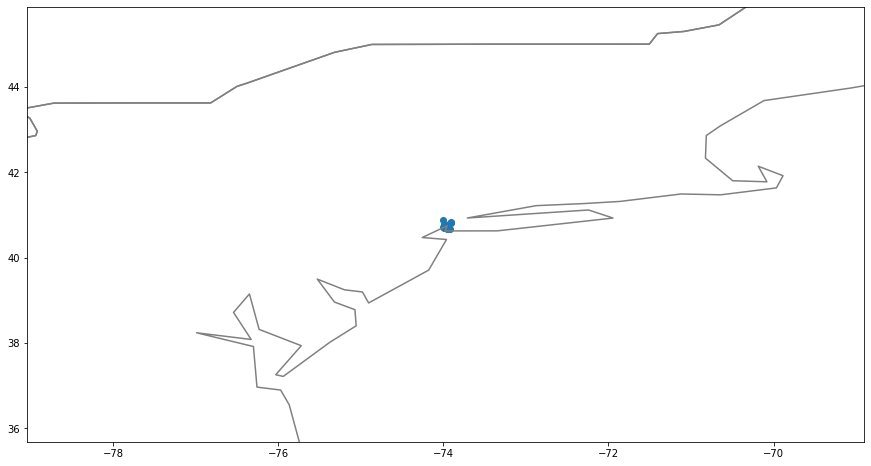

In [33]:
NE, SW = get_town_range_coordinates_cached('Manhattan', my_google_maps_api_key)
draw_earth(xlim=(SW[0] - 5, NE[0] + 5), ylim=(SW[1] - 5, NE[1] + 5))
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()

# 5. [M] Master level

You know, that you can implement an arbitrary metric? To get full points your task will be the following:

1. Choose a small sample of the original data (e.g. 10K New York points).
2. Describe each point with coordinate vector and discrete set of words in the name. **Design the metric function** -- a function, which accepts 2 objects and returns a number. This function should esimate "distance" in a merged space of words and distances. No common words? Far. Both common words and vectors are similar? Close!
3. **Use this metric in index data structure**. Maybe you will [extend nmslib](https://github.com/nmslib/nmslib/issues/478), maybe you will prefer my [NSW implementation](https://github.com/IUCVLab/proximity-cut/blob/master/modules/nsw/nsw.py) ([usage](https://github.com/IUCVLab/proximity-cut/blob/master/tests/nsw-visualization.ipynb), [custom HVDM metric](https://github.com/IUCVLab/proximity-cut/blob/master/modules/tools/hvdm.py), custom metric application -- pass `dist=func` into constructor). Or maybe you will find a data structure which supports this from the box :)
4. Run some tests!

## 5.1. Sample some data

In [34]:
random.seed(42)

ny_points = random.sample(get_in_town('New York', spaidx, GEO, my_google_maps_api_key), 10000)

New York -> New York, United States


## 5.2. [M][10 points] Metric which accepts 2 dataset items and returns metric

In [35]:
import scipy

def my_dist(a, b):
    ap, bp = a[0], b[0]
    atxt, btxt = a[1], b[1]

    def BoW(txt: str):
        return set(x.strip(" ,.?!'\"&/") for x in txt.split())

    atxt, btxt = BoW(atxt), BoW(btxt)

    bow_diff = (len(atxt - btxt) + len(btxt - atxt)) / (len(atxt) + len(btxt))
    vec_diff = scipy.spatial.distance.cosine(ap, bp)

    return np.sqrt(bow_diff ** 2 + vec_diff ** 2)

## 5.3. [M][25 points] Build an index

In [36]:
# TODO your code here

## 5.4. [M][10 points] write and pass some test

In [37]:
def find(town, query, index):
    # TODO your code here
    return []

In [38]:
find("Manhattan", "coffee")

TypeError: find() missing 1 required positional argument: 'index'